1. Importation des bibliothèques

In [8]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt


2. Chargement des données

In [9]:
df_earthquake = pd.read_csv("earthquakes.csv")

df = df_earthquake.drop(['postcode', 'subnational', 'continent', 'city'], axis=1)


3. Sélection des colonnes numériques

In [10]:
df_numeric_columns = df.select_dtypes(include=['number'])
df_numeric = df[df_numeric_columns.columns]


4. Winsorisation des colonnes numériques

In [12]:
def winsorized_column(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower=lower_bound, upper=upper_bound)

for col in df_numeric.columns:
    df_numeric[col] = winsorized_column(df_numeric[col])


C:\Users\hp\AppData\Local\Temp\ipykernel_4928\2370397244.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[col] = winsorized_column(df_numeric[col])
C:\Users\hp\AppData\Local\Temp\ipykernel_4928\2370397244.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[col] = winsorized_column(df_numeric[col])
C:\Users\hp\AppData\Local\Temp\ipykernel_4928\2370397244.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

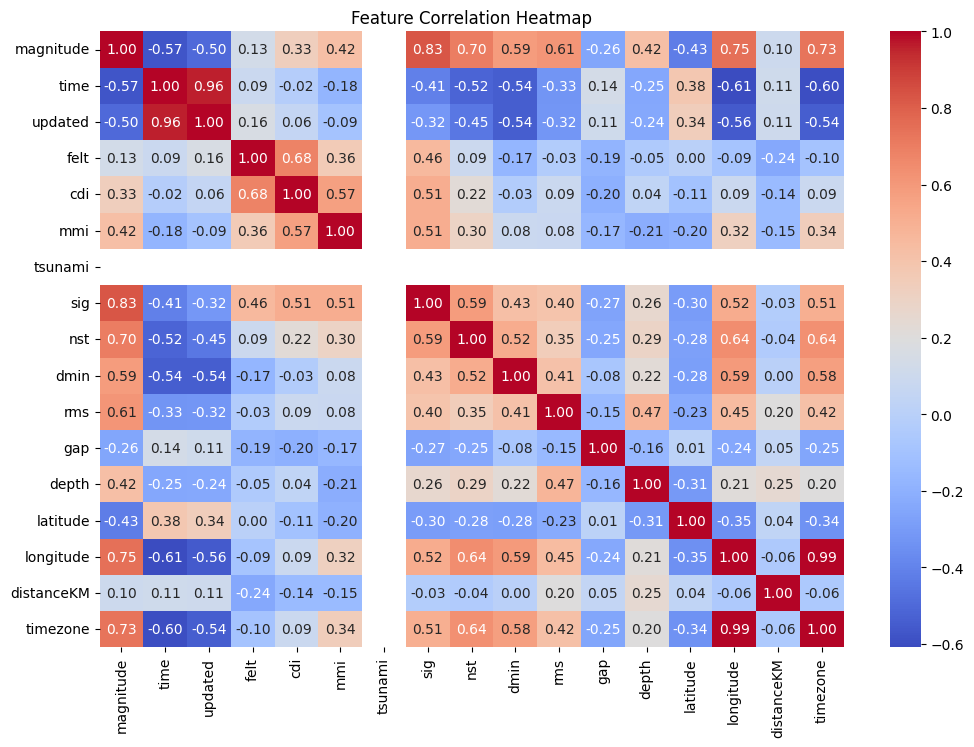

In [13]:
correlation = df_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


6. Préparation des données pour le modèle

In [14]:
X = df_numeric[['timezone', 'longitude', 'latitude', 'depth', 'rms', 'cdi',
                'mmi', 'tsunami', 'sig', 'nst', 'dmin', 'time', 'updated']]
Y = df_numeric['magnitude']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


7. Construction et entraînement du modèle

In [15]:
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_regressor.fit(X_train, Y_train)

GradientBoostingRegressor(random_state=42)

8. Prédictions et métriques

In [16]:
Y_pred = gb_regressor.predict(X_test)

rmse = mean_squared_error(Y_test, Y_pred, squared=False)
r2 = r2_score(Y_test, Y_pred)

print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")


RMSE: 0.10512933409394083
R^2 Score: 0.9897583124649685


C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9. Importance des caractéristiques

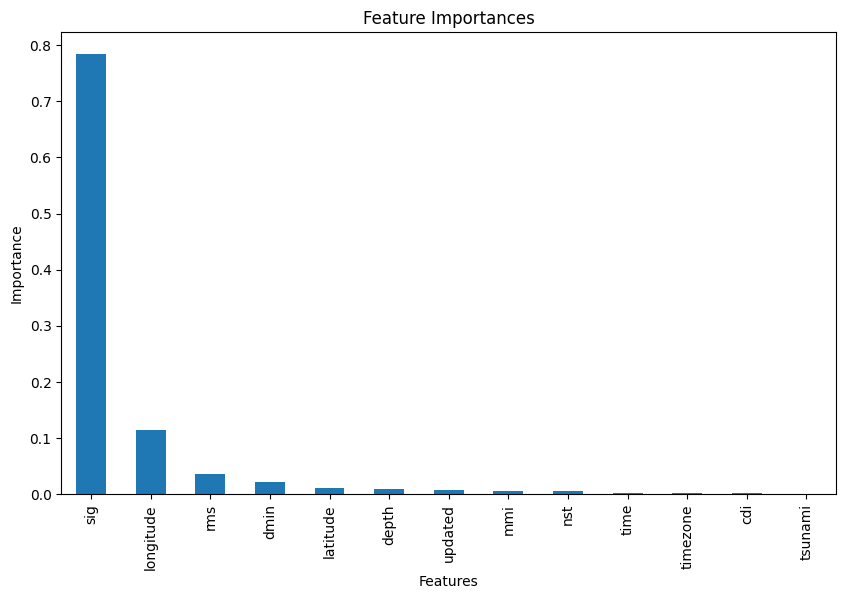

In [17]:
feature_importances = pd.Series(gb_regressor.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


10. Validation croisée

In [18]:
def cross_val(model):
    pred = cross_val_score(model, X_train, Y_train, cv=10)
    return pred.mean()

cv_score = cross_val(gb_regressor)
print(f"Cross-validation Score: {cv_score}")


Cross-validation Score: 0.9698484441526233


11. Fonctions d’évaluation

In [19]:
def map_score(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    mape = map_score(true, predicted)
    r2_square = metrics.r2_score(true, predicted)

    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAPE:", mape)
    print("R2 Score:", r2_square)

12. Évaluation des ensembles d’entraînement et de test

In [20]:
train_pred = gb_regressor.predict(X_train)
test_pred = gb_regressor.predict(X_test)

print("Training Set Evaluation:")
print_evaluate(Y_train, train_pred)

print("Testing Set Evaluation:")
print_evaluate(Y_test, test_pred)


Training Set Evaluation:
MAE: 0.053724105510649864
MSE: 0.00744472366068376
RMSE: 0.08628281208145548
MAPE: 1.146130097179767
R2 Score: 0.9932322662432247
Testing Set Evaluation:
MAE: 0.06422854069530422
MSE: 0.011052176887035432
RMSE: 0.10512933409394083
MAPE: 1.3811914736784874
R2 Score: 0.9897583124649685


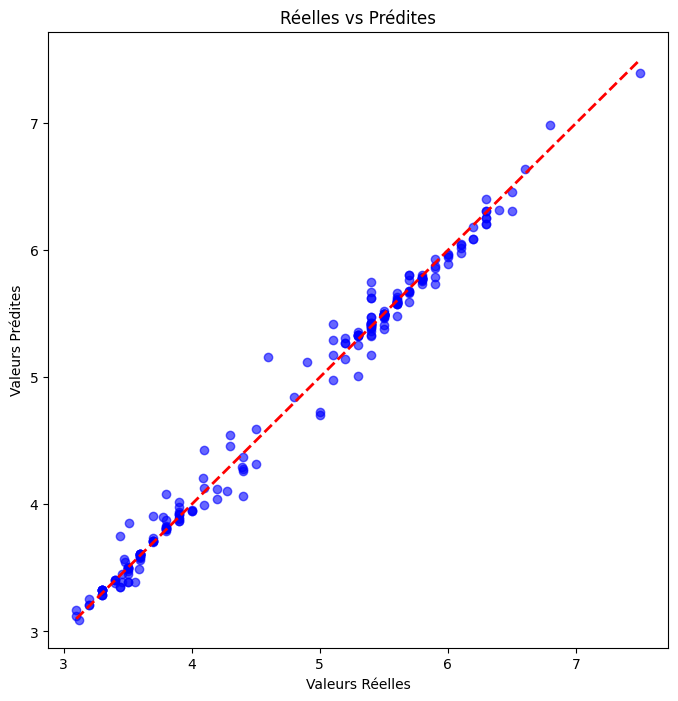

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(Y_test, Y_pred, alpha=0.6, color='blue')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)  # Ligne y=x
plt.xlabel("Valeurs Réelles")
plt.ylabel("Valeurs Prédites")
plt.title("Réelles vs Prédites")
plt.show()
